### Modelo V1: CNN usando Binary Cross-Entropy:

Este modelo es una red neuronal convolucional (CNN) que utiliza la función de loss Binary Cross-Entropy. Aquí, como usamos esta función loss, el modelo da el mismo peso a errores en la predicción de las dos clases:

- Viva $\equiv$ 1
- Muerta $\equiv$ 0 

La función de loss es de la forma:

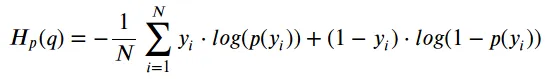

1. **Setup:** Importamos bibliotecas y obtenemos los caminos a los directorios con los datos ofrecidos por el propio Kaggle.

**Bibliotecas usadas:**
- os: para movernos por el sistema.
- pandas: lectura de archivos.
- matplotlib.pyplot: graficación de los resultados.
- keras: contiene las funciones necesarias para crear un modelo.
- numpy: para operaciones matemáticas.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as ks
import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Conv2DTranspose, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# 1. Define la semilla
SEED = 42  # Según ChatGPT es la mejor
 
# 2. Python built-in random
random.seed(SEED)

# 3. NumPy
np.random.seed(SEED)

# 4. TensorFlow
tf.random.set_seed(SEED)

# (Opcional) Para TensorFlow más determinismo en operaciones GPU:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

path = "../Datos"
datos = []
for dirnames,_,filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('.xlsx'):
            datos.append(os.path.join(dirnames,filename))

print(datos)

['../Datos\\test.xlsx', '../Datos\\train.xlsx']


2. **Creación del modelo:** 

Definimos primero las métricas y luego el modelo:

In [ ]:
# ---------------- Métricas  ----------------
def Accuracy(y_true, y_pred):
    y_pred_rounded = K.round(K.clip(y_pred, 0, 1))
    correct = K.equal(y_true, y_pred_rounded)
    return K.mean(K.cast(correct, K.floatx()))

def Precision(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    predicted_positives = K.sum(y_pred_pos)
    return tp / (predicted_positives + K.epsilon())

def Specificity(y_true, y_pred):
    y_pred_neg = 1 - K.round(K.clip(y_pred, 0, 1))
    y_true_neg = 1 - y_true
    tn = K.sum(y_true_neg * y_pred_neg)
    possible_negatives = K.sum(y_true_neg)
    return tn / (possible_negatives + K.epsilon())

def Recall(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    tp = K.sum(y_true * y_pred_pos)
    possible_positives = K.sum(y_true)
    return tp / (possible_positives + K.epsilon())

def F1_score(y_true, y_pred):
    prec = Precision(y_true, y_pred)
    rec = Recall(y_true, y_pred)
    return 2 * (prec * rec) / (prec + rec + K.epsilon())

def Hamming_loss(y_true, y_pred):
    mismatches = K.not_equal(K.round(K.clip(y_pred, 0, 1)), y_true)
    return K.mean(K.cast(mismatches, K.floatx()))

In [3]:

def create_model(n_hidden_convs=2, n_hidden_filters=128, kernel_size=5):
    nn = Sequential()
    nn.add(Conv2D(n_hidden_filters, kernel_size,
                  padding='same', activation='relu',
                  input_shape=(20, 20, 1)))
    nn.add(BatchNormalization())
    for _ in range(n_hidden_convs):
        nn.add(Conv2D(n_hidden_filters, kernel_size,
                      padding='same', activation='relu'))
        nn.add(BatchNormalization())
    nn.add(Conv2D(1, kernel_size, padding='same', activation='sigmoid'))

    nn.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[Accuracy, Precision, Specificity, Recall, F1_score, Hamming_loss])
    return nn


3. **Cargamos los datos:** Recordemos que los datos del Kaggle están ordenados en formato column-wise order. (Explicado en la tablet)

In [4]:
# Cargo los datos:
train = pd.read_excel(datos[1], sheet_name = 'train', header = 0)

# Creo una lista con los nombres de los headers de los tableros:
starts = [f'start.{i}' for i in range(1,401)]
stops = [f'stop.{i}' for i in range(1,401)]

4. **Entreamiento del modelo:**

In [5]:
# Entrenamiento de 5 modelos, uno para cada delta:

models = [] # Almacén de modelos (parámetros optimizados)
historial = [] # Almacén de historiales (loss, accurracy)

for i in range(1,6):
    # Obtenemos los datos para cada delta:
    delta_i = train[train['delta'] == i]
    finales_i = np.reshape(delta_i[stops].values, (-1,20,20,1), order='F')
    iniciales_i = np.reshape(delta_i[starts].values, (-1,20,20,1), order='F')
    
    # Entrenamos al modelo
    model = create_model(n_hidden_convs=6, n_hidden_filters=256)
    es = EarlyStopping(monitor='loss', patience=9, min_delta=0.001)
    history = model.fit(finales_i, iniciales_i, epochs=50, verbose=1, callbacks=[es])
    models.append(model)
    historial.append(history)


Epoch 1/50
309/309 [==============================] - 62s 169ms/step - loss: 0.3640 - Accuracy: 0.8366 - Precision: 0.4965 - Specificity: 0.9221 - Recall: 0.3336 - F1_score: 0.3594 - Hamming_loss: 0.1634
Epoch 2/50
309/309 [==============================] - 53s 171ms/step - loss: 0.2008 - Accuracy: 0.9135 - Precision: 0.7363 - Specificity: 0.9610 - Recall: 0.6343 - F1_score: 0.6794 - Hamming_loss: 0.0865
Epoch 3/50
309/309 [==============================] - 54s 176ms/step - loss: 0.1807 - Accuracy: 0.9249 - Precision: 0.7726 - Specificity: 0.9650 - Recall: 0.6894 - F1_score: 0.7267 - Hamming_loss: 0.0751
Epoch 4/50
309/309 [==============================] - 52s 167ms/step - loss: 0.1714 - Accuracy: 0.9296 - Precision: 0.7872 - Specificity: 0.9670 - Recall: 0.7100 - F1_score: 0.7451 - Hamming_loss: 0.0704
Epoch 5/50
309/309 [==============================] - 52s 169ms/step - loss: 0.1625 - Accuracy: 0.9343 - Precision: 0.8005 - Specificity: 0.9688 - Recall: 0.7314 - F1_score: 0.7635 - H

**5. Guardamos todo para reutilizarlo cuando queramos:** De esta forma no tenemos que ejecutar todo el notebook cada vez.

In [6]:
# Convertimos el diccionario de historial en un DataFrame:
df_history1 = pd.DataFrame(historial[0].history)
df_history2= pd.DataFrame(historial[1].history)
df_history3 = pd.DataFrame(historial[2].history)
df_history4 = pd.DataFrame(historial[3].history)
df_history5 = pd.DataFrame(historial[4].history)

# Guardamos el DataFrame en un archivo Excel:
df_history1.to_excel('../Modelo V1/Historial Entrenamiento/historialV1_delta1.xlsx', index=False)
df_history2.to_excel('../Modelo V1/Historial Entrenamiento/historialV1_delta2.xlsx', index=False)
df_history3.to_excel('../Modelo V1/Historial Entrenamiento/historialV1_delta3.xlsx', index=False)
df_history4.to_excel('../Modelo V1/Historial Entrenamiento/historialV1_delta4.xlsx', index=False)
df_history5.to_excel('../Modelo V1/Historial Entrenamiento/historialV1_delta5.xlsx', index=False)

# Guardamos los modelos
for i, model in enumerate(models):
    model.save(f"../Modelo V1/Pesos Modelos/modeloV1_delta_{i+1}", save_format='tf')


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_1\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_1\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_2\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_2\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_3\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_3\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_4\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_4\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_5\assets


INFO:tensorflow:Assets written to: ../Modelo V1/Pesos Modelos/modeloV1_delta_5\assets
